In [1]:
# You code here

In [2]:
# Solution code

import math


def nCr(n, r):
    f = math.factorial
    return f(n) / f(r) / f(n - r)


p, N, m, s = 0.75, 9, 5, 0

for i in range(m, N + 1):
    s += nCr(N, i) * p ** i * (1 - p) ** (N - i)
print(round(s * 100, 2), "%")

95.11 %


In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sharper plots
%config InlineBackend.figure_format = 'retina'

In [4]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [5]:
PATH_TO_DATA = Path("../../_static/data/assignment5/")

In [6]:
data = pd.read_csv(PATH_TO_DATA / "credit_scoring_sample.csv.zip", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [7]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

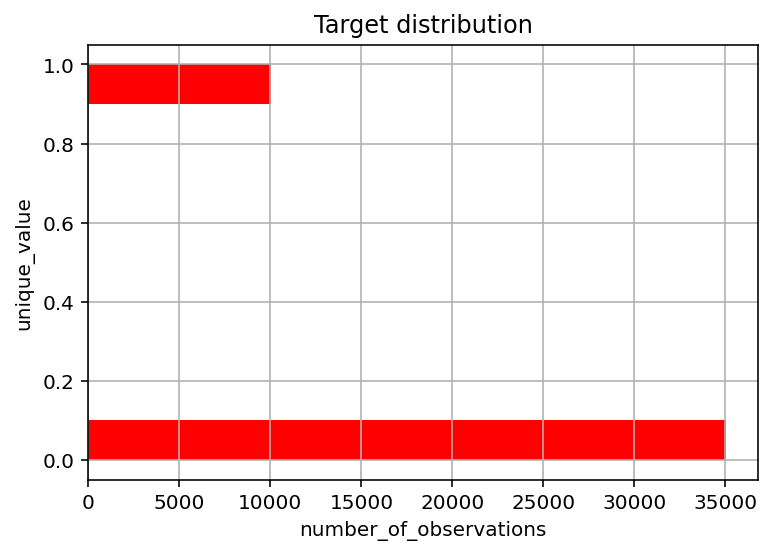

In [8]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target:")
data["SeriousDlqin2yrs"].value_counts(normalize=True)

In [9]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [10]:
table = impute_nan_with_median(data)

In [11]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

In [12]:
# you'll be asked to fix this seed (`random_state`) everywhere in this notebook
SEED = 17

In [13]:
# You code here

In [14]:
# Solution code


def get_bootstrap_samples(data, n_samples, seed=SEED):
    # Function to generate subsamples with bootstrap
    np.random.seed(seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    # Function for interval estimates
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries


# Save data about overdues in different numpy arrays
churn = data[data["SeriousDlqin2yrs"] == 1]["MonthlyIncome"].values
not_churn = data[data["SeriousDlqin2yrs"] == 0]["MonthlyIncome"].values

# Generate bootstrap samples and calculate the means
churn_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(churn, 2000, seed=SEED)
]
not_churn_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(not_churn, 2000, seed=SEED)
]

#  Derive interval estimate of the mean
print("Bad customers mean interval", stat_intervals(churn_mean_scores, 0.2))
print("Good customers mean interval", stat_intervals(not_churn_mean_scores, 0.2))
print(
    "Difference is",
    stat_intervals(not_churn_mean_scores, 0.2)[1]
    - stat_intervals(churn_mean_scores, 0.2)[0],
)

Bad customers mean interval [5482.66379414 5625.22886495]
Good customers mean interval [6310.92322402 6478.45869224]
Difference is 995.7948981043837


In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [16]:
dt = DecisionTreeClassifier(random_state=SEED, class_weight="balanced")

In [17]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {"max_depth": max_depth_values, "max_features": max_features_values}

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [19]:
# Solution code

dt_grid_search = GridSearchCV(dt, tree_params, n_jobs=-1, scoring="roc_auc", cv=skf)
dt_grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'max_features': [4, 5, 6, 7]},
             scoring='roc_auc')

In [20]:
# Solution code

round(float(dt_grid_search.best_score_), 2)

0.82

In [21]:
# Solution code

dt_grid_search.best_params_

{'max_depth': 7, 'max_features': 6}

In [22]:
# Solution code

dt_grid_search.cv_results_["std_test_score"][
    np.argmax(dt_grid_search.cv_results_["mean_test_score"])
]

0.0038920985350028546

In [23]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score


class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=10, max_features=10, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        # You code here
        pass

        # Solution code
        
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators):

            np.random.seed(self.random_state + i)
            feat_to_use_ids = np.random.choice(
                range(X.shape[1]), self.max_features, replace=False
            )
            examples_to_use = list(
                set(np.random.choice(range(X.shape[0]), X.shape[0], replace=True))
            )

            self.feat_ids_by_tree.append(feat_to_use_ids)

            dt = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state,
            )

            dt.fit(X[examples_to_use, :][:, feat_to_use_ids], y[examples_to_use])
            self.trees.append(dt)
        return self

    def predict_proba(self, X):
        # You code here
        pass

        # Solution code
        predictions = []
        for i in range(self.n_estimators):
            feat_to_use_ids = self.feat_ids_by_tree[i]
            predictions.append(self.trees[i].predict_proba(X[:, feat_to_use_ids]))
        return np.mean(predictions, axis=0)
    
    def predict(self, X):
        # You code here
        pass

        # Solution code
        predictions = []
        for i in range(self.n_estimators):
            feat_to_use_ids = self.feat_ids_by_tree[i]
            predictions.append(self.trees[i].predict_proba(X[:, feat_to_use_ids]))
        return np.mean(predictions, axis=0)

In [24]:
# You code here

In [25]:
%%time

# Solution code
cv_aucs = cross_val_score(
    RandomForestClassifierCustom(max_depth=7, max_features=6),
    X.values,
    y.values,
    scoring="roc_auc",
    cv=skf,
)
print("Mean ROC AUC for your own RF:", np.mean(cv_aucs))

Mean ROC AUC for your own RF: 0.8324389040118156
CPU times: user 2.25 s, sys: 27.5 ms, total: 2.28 s
Wall time: 2.29 s


In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
# You code here

In [28]:
# Solution code

cv_aucs = cross_val_score(
    RandomForestClassifier(
        n_estimators=10,
        max_depth=7,
        max_features=6,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced",
    ),
    X.values,
    y.values,
    scoring="roc_auc",
    cv=skf,
)
print("Mean ROC AUC for sklearn RF:", np.mean(cv_aucs))

Mean ROC AUC for sklearn RF: 0.8294245044403752


In [29]:
max_depth_values = range(5, 15)
max_features_values = [4, 5, 6, 7]
forest_params = {"max_depth": max_depth_values, "max_features": max_features_values}

In [30]:
# You code here

In [31]:
%%time

# Solution code
rf = RandomForestClassifier(
    n_estimators=10, random_state=SEED, n_jobs=-1, class_weight="balanced"
)
rf_grid_search = GridSearchCV(rf, forest_params, n_jobs=-1, scoring="roc_auc", cv=skf)
rf_grid_search.fit(X.values, y.values)

CPU times: user 1.14 s, sys: 121 ms, total: 1.26 s
Wall time: 15.9 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_estimators=10, n_jobs=-1,
                                              random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 15),
                         'max_features': [4, 5, 6, 7]},
             scoring='roc_auc')

In [32]:
# Solution code
rf_grid_search.best_score_

0.8309382382771451

In [33]:
# Solution code
rf_grid_search.best_params_

{'max_depth': 8, 'max_features': 5}

In [34]:
# Solution code
rf_grid_search.cv_results_["std_test_score"][
    np.argmax(rf_grid_search.cv_results_["mean_test_score"])
]

0.002850452942332219

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
logit = LogisticRegression(
    random_state=SEED, solver="liblinear", class_weight="balanced"
)

logit_pipe = Pipeline([("scaler", scaler), ("logit", logit)])
logit_pipe_params = {"logit__C": np.logspace(-8, 8, 17)}

In [36]:
# You code here

In [37]:
%%time

# Solution code
logit_pipe_grid_search = GridSearchCV(
    logit_pipe, logit_pipe_params, n_jobs=-1, scoring="roc_auc", cv=skf
)
logit_pipe_grid_search.fit(X.values, y.values)

CPU times: user 291 ms, sys: 61.6 ms, total: 353 ms
Wall time: 2.96 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logit',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=17,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logit__C': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])},
             scoring='roc_auc')

In [38]:
# Solution code
logit_pipe_grid_search.best_score_

0.7880668344494914

In [39]:
# Solution code
logit_pipe_grid_search.best_params_

{'logit__C': 10000.0}

In [40]:
# Solution code
logit_pipe_grid_search.cv_results_["std_test_score"][
    np.argmax(logit_pipe_grid_search.cv_results_["mean_test_score"])
]

0.0047244925974075985

In [41]:
# Download data
df = pd.read_csv(PATH_TO_DATA / "movie_reviews_train.csv.zip", nrows=50000)

# Split data to train and test
X_text = df["text"]
y_text = df["label"]

# Classes counts
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# In Pipeline we will modify the text and train logistic regression
classifier = Pipeline(
    [
        ("vectorizer", CountVectorizer(max_features=100000, ngram_range=(1, 3))),
        ("clf", LogisticRegression(solver="liblinear", random_state=SEED)),
    ]
)

In [43]:
# You code here

In [44]:
%%time

# Solution code
parameters = {"clf__C": (0.1, 1, 10, 100)}
grid_search = GridSearchCV(classifier, parameters, n_jobs=-1, scoring="roc_auc", cv=skf)
grid_search = grid_search.fit(X_text, y_text)

CPU times: user 19.8 s, sys: 2.66 s, total: 22.5 s
Wall time: 33 s


In [45]:
# Solution code
grid_search.best_params_

{'clf__C': 1}

In [46]:
# Solution code
grid_search.best_score_

0.8588061001539203

In [47]:
classifier = Pipeline(
    [
        ("vectorizer", CountVectorizer(max_features=100000, ngram_range=(1, 3))),
        ("clf", RandomForestClassifier(n_estimators=10, random_state=SEED, n_jobs=-1)),
    ]
)

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [48]:
# You code here

In [49]:
%%time

# Solution code
# We comment out the last line for easier reproducibility, 
# this step takes ~12 min. to complete
parameters = {
    "clf__max_features": max_features,
    "clf__min_samples_leaf": min_samples_leaf,
    "clf__max_depth": max_depth,
}
grid_search = GridSearchCV(classifier, parameters, n_jobs=-1, scoring="roc_auc", cv=skf)
# grid_search = grid_search.fit(X_text, y_text)

CPU times: user 277 ms, sys: 65.1 ms, total: 342 ms
Wall time: 80.5 ms


In [50]:
# Solution code
#grid_search.best_params_
# {'clf__max_depth': None, 'clf__max_features': 0.3, 'clf__min_samples_leaf': 2}

In [51]:
# Solution code
#grid_search.best_score_
# 0.7505612411768879